In [1]:
import os
import json
import numpy as np
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image
from tqdm import tqdm
from tokenizers import Tokenizer
from transformers import ViTFeatureExtractor, ViTModel, PreTrainedModel, PretrainedConfig, PreTrainedTokenizerFast, AutoConfig, AutoModelForCausalLM
from transformers.models.auto.configuration_auto import CONFIG_MAPPING
from transformers.models.auto.modeling_auto import MODEL_FOR_CAUSAL_LM_MAPPING

import torch   
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from models.GUMI_T_ViTFC_model import *

2026-02-13 13:37:54.617249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-13 13:37:54.627884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-13 13:37:54.630933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-13 13:37:54.638970: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2026-02-13 13:37:55.974513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
NO_WORD_IMAGE_ONLY = True
REAL_IMAGE_ONLY = True
REAL_IMAGE_THRESHOLD = 0.75
NO_UNIQUE_NOUN_SENTENCE_ONLY = True

MAX_SENTENCE_LENGTH = 31
MIN_SENTENCE_LENGTH = 4
MIN_FREQUENCY = 16

NUM_TRANSFORMER_LAYERS = 5 # 1, 2, 3, 4, 5
NUM_HEADS = 8 # 固定

LERNING_RATE = 0.0001 # 0.001, 0.0001, 0.00001
BATCH_SIZE = 32 # 32, 128, 512
EPOCHS = 50 # 固定
HIDDEN_DIM = 1024 # 固定

result_dir = f"../results/GUMI_T_ViT_FineTuining/{NO_WORD_IMAGE_ONLY}_{REAL_IMAGE_ONLY}_{REAL_IMAGE_THRESHOLD}_{NO_UNIQUE_NOUN_SENTENCE_ONLY}_{MAX_SENTENCE_LENGTH}_{MIN_SENTENCE_LENGTH}_{MIN_FREQUENCY}_{NUM_TRANSFORMER_LAYERS}_{NUM_HEADS}_{LERNING_RATE}_{BATCH_SIZE}_{EPOCHS}_{HIDDEN_DIM}/"
os.makedirs(result_dir, exist_ok= True)
with open(f"{result_dir}training_config.json", "w") as f:
    json.dump({
        "NO_WORD_IMAGE_ONLY": NO_WORD_IMAGE_ONLY,
        "REAL_IMAGE_ONLY": REAL_IMAGE_ONLY,
        "REAL_IMAGE_THRESHOLD": REAL_IMAGE_THRESHOLD,
        "NO_UNIQUE_NOUN_SENTENCE_ONLY": NO_UNIQUE_NOUN_SENTENCE_ONLY,

        "MAX_SENTENCE_LENGTH": MAX_SENTENCE_LENGTH,
        "MIN_SENTENCE_LENGTH": MIN_SENTENCE_LENGTH,
        "MIN_FREQUENCY": MIN_FREQUENCY,

        "NUM_TRANSFORMER_LAYERS": NUM_TRANSFORMER_LAYERS,
        "NUM_HEADS": NUM_HEADS,

        "LERNING_RATE": LERNING_RATE,
        "BATCH_SIZE": BATCH_SIZE,
        "EPOCHS": EPOCHS,
        "HIDDEN_DIM": HIDDEN_DIM
    }, f)

#
result_dir

'../results/GUMI_T_ViT_FineTuining/True_True_0.75_True_31_4_16_5_8_0.0001_32_50_1024/'

In [ ]:
IMAGE_DIR = "../datas/Bokete_Dataset/boke_image/"
data_dir = f"../datas/{NO_WORD_IMAGE_ONLY}_{REAL_IMAGE_ONLY}_{REAL_IMAGE_THRESHOLD}_{NO_UNIQUE_NOUN_SENTENCE_ONLY}_{MAX_SENTENCE_LENGTH}_{MIN_SENTENCE_LENGTH}_{MIN_FREQUENCY}/"

train_inputs_1 = np.load(f"{data_dir}train_inputs_1.npy")
train_inputs_2 = np.load(f"{data_dir}train_inputs_2.npy")
train_teacher_signals = np.load(f"{data_dir}train_teacher_signals.npy")
test_inputs_1 = np.load(f"{data_dir}test_inputs_1.npy")
test_inputs_2 = np.load(f"{data_dir}test_inputs_2.npy")
test_teacher_signals = np.load(f"{data_dir}test_teacher_signals.npy")
tokenizer = Tokenizer.from_file(f"{data_dir}tokenizer.json")
VOCAB_SIZE = tokenizer.get_vocab_size()

tokenizer.save(f"{result_dir}tokenizer.json")

#
train_inputs_1.shape, train_inputs_2.shape, train_teacher_signals.shape, test_inputs_1.shape, test_inputs_2.shape, test_teacher_signals.shape, VOCAB_SIZE

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "google/vit-base-patch16-224-in21k"
image_preprocesser = ViTFeatureExtractor.from_pretrained(model_name)

/home/user/Colab_20250113/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
def make_image_dataloader(inputs_1, inputs_2, test_teacher_signals):
    class LoadImageDataset(Dataset):
        def __init__(self, inputs_1, inputs_2, test_teacher_signals):
            """
                inputs_1: 画像の番号からなるリスト
                inputs_2: 入力文からなるリスト
                test_teacher_signals: 教師信号からなるリスト
            """
            if len(inputs_1) != len(inputs_2):
                raise ValueError("inputs_1 and inputs_2 must have the same length.")
            if len(inputs_1) != len(test_teacher_signals):
                raise ValueError("inputs_1 and test_teacher_signals must have the same length.")

            self.inputs_1 = inputs_1
            self.inputs_2 = inputs_2
            self.test_teacher_signals = test_teacher_signals

        def __len__(self):
            return len(self.inputs_1)

        def __getitem__(self, idx):
            image = Image.open(f"{IMAGE_DIR}{self.inputs_1[idx]}.jpg").convert("RGB")
            input_sentence = torch.Tensor( self.inputs_2[idx] ).to(torch.int64)
            teacher_signal = torch.Tensor( self.test_teacher_signals[idx] ).to(torch.int64)
            
            return image, input_sentence, teacher_signal

    def collate_fn(batch):
        images, input_sentences, teacher_signals = zip(*batch)
        
        images = image_preprocesser(images = images, return_tensors = "pt")
        input_sentences = torch.stack(input_sentences, dim = 0)
        teacher_signals = torch.stack(teacher_signals, dim = 0)
        
        return images, input_sentences, teacher_signals

    dataset = LoadImageDataset(inputs_1, inputs_2, test_teacher_signals)
    dataloader = DataLoader(
        dataset, 
        batch_size = BATCH_SIZE, 
        num_workers = int(os.cpu_count() * 0.6), 
        shuffle = True,
        collate_fn = collate_fn
    )

    return dataloader

train_dataloader = make_image_dataloader(train_inputs_1, train_inputs_2, train_teacher_signals)
test_dataloader = make_image_dataloader(test_inputs_1, test_inputs_2, test_teacher_signals)

#
i1, i2, t = next(iter(train_dataloader))
i1["pixel_values"].shape, i2.shape, t.shape

In [ ]:
generator = TransformerSentenceGeneratorViTFC(
    num_transformer_layers = NUM_TRANSFORMER_LAYERS,
    num_heads = NUM_HEADS,
    vocab_size = len(tokenizer.get_vocab()), 
    input_length = MAX_SENTENCE_LENGTH + 1, 
    hidden_dim = HIDDEN_DIM, 
    patch_dim = 768) # pathc_dimはViTの出力次元数
print(f"num parameter: {sum(p.numel() for p in generator.parameters())}")

START_EPOCH = 0
train_loss_history = list()
test_loss_history = list()
train_acc_history = list()
test_acc_history = list()
train_perplexity_history = list()
test_perplexity_history = list()

# 学習履歴がある場合，途中から再開する
if os.path.exists(f"{result_dir}train_history.json"):
    with open(f"{result_dir}train_history.json", "r") as f:
        history = json.load(f)
        train_loss_history = history["train_loss_history"]
        test_loss_history = history["test_loss_history"]
        train_acc_history = history["train_acc_history"]
        test_acc_history = history["test_acc_history"]
        train_perplexity_history = history["train_perplexity_history"]
        test_perplexity_history = history["test_perplexity_history"]
    
    START_EPOCH = len(train_loss_history)
    generator.load_state_dict(torch.load(f"{result_dir}generator_{START_EPOCH}.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
optimizer = optim.AdamW(generator.parameters(), lr = LERNING_RATE)

def calculate_accuracy(outputs, teacher_signals):
    _, predicted = torch.max(outputs, dim=-1)
    mask = teacher_signals != 0
    
    correct = (predicted == teacher_signals) & mask 
    correct = correct.sum().item()
    
    total = mask.sum().item()
    accuracy = correct / total if total > 0 else 0
    return accuracy

def calculate_perplexity(loss):
    return torch.exp(loss)

def train_step(generator, optimizer, inputs_1, inputs_2, teacher_signals):
    generator.train()
    optimizer.zero_grad()

    inputs_1 = inputs_1.to(device)
    inputs_2 = inputs_2.to(device)
    teacher_signals = teacher_signals.to(device)

    outputs = generator(inputs_2, inputs_1)
    
    outputs = outputs.view(-1, outputs.size(-1))  # [32*32, 8192]
    teacher_signals = teacher_signals.view(-1)    # [32*32]

    loss = F.cross_entropy(outputs, teacher_signals, 
                           ignore_index = 0)
    loss.backward()
    optimizer.step()

    accuracy = calculate_accuracy(outputs, teacher_signals)
    perplexity = calculate_perplexity(loss)

    return loss.item(), accuracy, perplexity.item()

def test_step(generator, inputs_1, inputs_2, teacher_signals):
    generator.eval()

    inputs_1 = inputs_1.to(device)
    inputs_2 = inputs_2.to(device)
    teacher_signals = teacher_signals.to(device)

    with torch.no_grad():
        outputs = generator(inputs_2, inputs_1)

        outputs = outputs.view(-1, outputs.size(-1))  # [32*32, 8192]
        teacher_signals = teacher_signals.view(-1)    # [32*32]

        loss = F.cross_entropy(outputs, teacher_signals, 
                               ignore_index = 0)
        accuracy = calculate_accuracy(outputs, teacher_signals)
        perplexity = calculate_perplexity(loss)

    return loss.item(), accuracy, perplexity.item()

for epoch in range(START_EPOCH, EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # train
    train_loss = 0
    train_accuracy = 0
    train_perplexity = 0
    total_samples = 0
    pb = tqdm(train_dataloader)
    for inputs_1, inputs_2, teacher_signals in pb:
        batch_size = inputs_2.size(0)

        loss, accuracy, perplexity = train_step(generator, optimizer, inputs_1, inputs_2, teacher_signals)

        train_loss += loss * batch_size
        train_accuracy += accuracy * batch_size
        train_perplexity += perplexity * batch_size
        total_samples += batch_size

        pb.set_postfix({"loss": train_loss / total_samples, "accuracy": train_accuracy / total_samples, "perplexity": train_perplexity / total_samples})
    train_loss /= total_samples
    train_accuracy /= total_samples
    train_perplexity /= total_samples

    # test
    test_loss = 0
    test_accuracy = 0
    test_perplexity = 0
    total_samples = 0
    pb = tqdm(test_dataloader)
    for inputs_1, inputs_2, teacher_signals in pb:
        batch_size = inputs_2.size(0)

        loss, accuracy, perplexity = test_step(generator, inputs_1, inputs_2, teacher_signals)

        test_loss += loss * batch_size
        test_accuracy += accuracy * batch_size
        test_perplexity += perplexity * batch_size
        total_samples += batch_size

        pb.set_postfix({"loss": test_loss / total_samples, "accuracy": test_accuracy / total_samples, "perplexity": test_perplexity / total_samples})
    test_loss /= total_samples
    test_accuracy /= total_samples
    test_perplexity /= total_samples

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Perplexity: {train_perplexity:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Perplexity: {test_perplexity:.4f}")

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(train_accuracy)
    test_acc_history.append(test_accuracy)
    train_perplexity_history.append(train_perplexity)
    test_perplexity_history.append(test_perplexity)
    with open(f"{result_dir}train_history.json", "w") as f:
        json.dump({
            "train_loss_history": train_loss_history,
            "test_loss_history": test_loss_history,
            "train_acc_history": train_acc_history,
            "test_acc_history": test_acc_history,
            "train_perplexity_history": train_perplexity_history,
            "test_perplexity_history": test_perplexity_history
        }, f)
    
    torch.save(generator.state_dict(), f"{result_dir}generator_{epoch + 1}.pth")
    if os.path.exists(f"{result_dir}generator_{epoch}.pth") and epoch % 5 != 0:
        os.remove(f"{result_dir}generator_{epoch}.pth")
    
    if min(train_loss_history) == train_loss:
        torch.save(generator.state_dict(), f"{result_dir}generator_best.pth")
        if os.path.exists(f"{result_dir}generator_best_{epoch}.pth"):
            os.remove(f"{result_dir}generator_best_{epoch}.pth")

    test_image_paths = list(sorted(set([f"{IMAGE_DIR}{IN}.jpg" for IN in test_inputs_1])))
    GUMI_T_ViTFC_generate_ohgiri(image_preprocesser, generator, test_image_paths[:5], tokenizer, sentence_length = MAX_SENTENCE_LENGTH)
    print("=" * 50)

# 学習結果を描画
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_loss_history, label = "train")
ax.plot(test_loss_history, label = "test")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
ax.grid()

fig.savefig(f"{result_dir}train_history.png")

# Predict

In [4]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file = f"{result_dir}tokenizer.json",)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = GUMI_T_ViTFC_Config(
    num_transformer_layers = NUM_TRANSFORMER_LAYERS,
    num_heads = NUM_HEADS,
    vocab_size = len(tokenizer.get_vocab()),
    input_length = MAX_SENTENCE_LENGTH + 1,
    hidden_dim = HIDDEN_DIM,
    patch_dim = 768
)
gumi_t = GUMI_T_ViTFC(
    config
)
gumi_t.load_weights(f"{result_dir}generator_best.pth")
gumi_t.to(device)
gumi_t.eval()
test_image_paths = [f"test_images/{IP}" for IP in sorted(os.listdir("test_images/"))]
inputs = {
    "pixel_values": [Image.open(path).convert("RGB") for path in test_image_paths]
}

/home/user/workspace/GUMI_T_Paper/GUMI_T_Paper_programs/models/GUMI_T_ViTFC_model.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.generator.load_state_dict(torch.

0 エア・輪ゴム鉄砲


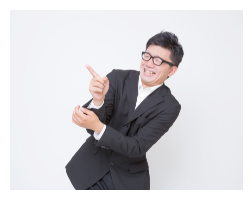

5 ベースにゴミが入った


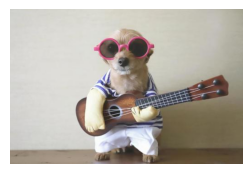

7 生まれる前に


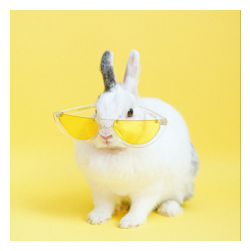

8 あーんパーンチ


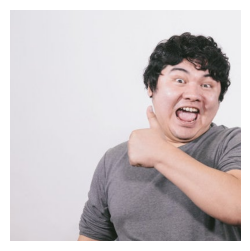

12 店員が呼んで来た


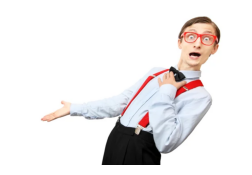

In [35]:
gen_text_indexies = gumi_t.generate(inputs, argmax = False)
gen_texts = gumi_t.decode(gen_text_indexies, tokenizer)

for i, (T, I) in enumerate(zip(gen_texts, inputs["pixel_values"])):

    if len(T) > 10: continue 
    
    print(i, T)
    fig = plt.figure(figsize = (3, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(I)
    ax.axis("off")
    plt.show()
    print("=" * 50)

In [6]:
with open(f"{result_dir}tokenizer.json", "r") as f:
    word_to_index = json.load(f)["model"]["vocab"]

In [36]:
from Japanese_BPEEncoder_V2.encode_swe import SWEEncoder_ja

with open('Japanese_BPEEncoder_V2/ja-swe32kfix.txt') as f:
    bpe = f.read().split('\n')

with open('Japanese_BPEEncoder_V2/emoji.json') as f:
    emoji = json.loads(f.read())

SWE_tokenizer = SWEEncoder_ja(bpe, emoji)

boke = "あーんパーンチ"
res = SWE_tokenizer.encode(boke)
res = [SWE_tokenizer.decode([I]) for I in res]

res

['あ', 'ー', 'ん', 'パー', 'ン', 'チ']

In [37]:
tmp_words = ["<BOS>", "弾", "き", "語", "り", "<EOS>"]
tmp_words = ["<BOS>"] + res + ["<EOS>"]
tmp_tokenized_words = [word_to_index[w] for w in tmp_words]
tmp_tokenized_words += [0] * (MAX_SENTENCE_LENGTH + 1 - len(tmp_tokenized_words))

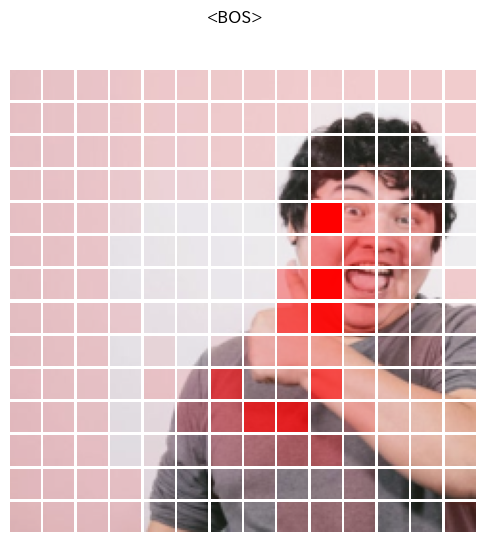

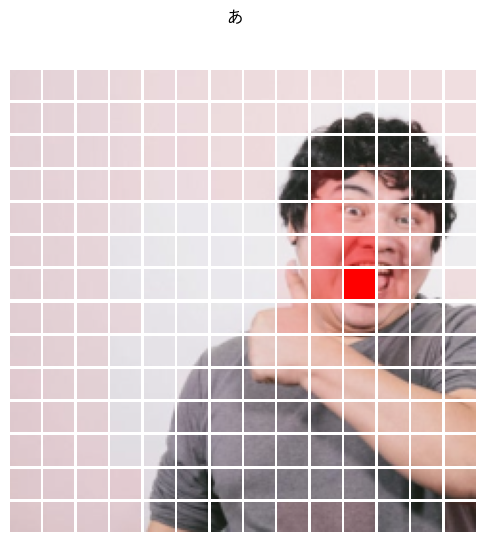

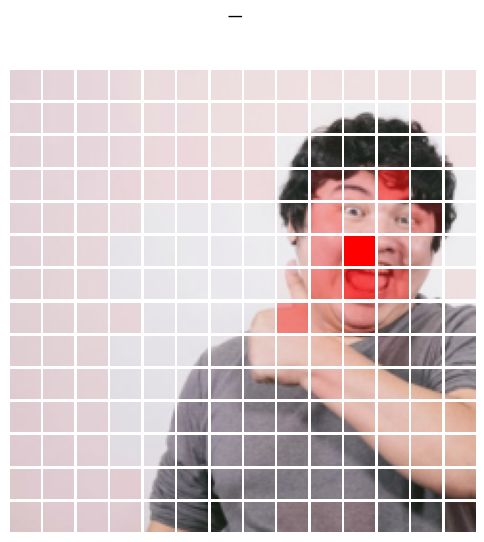

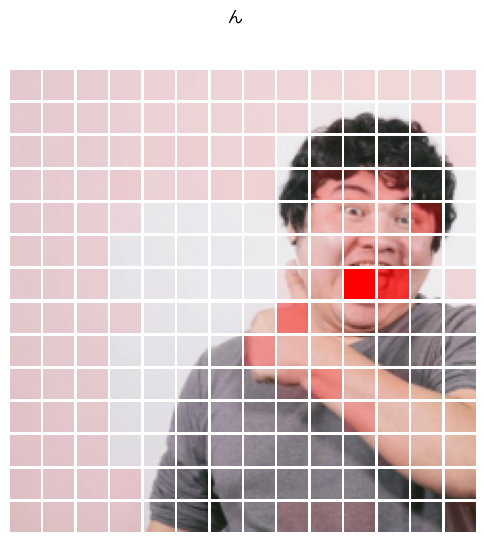

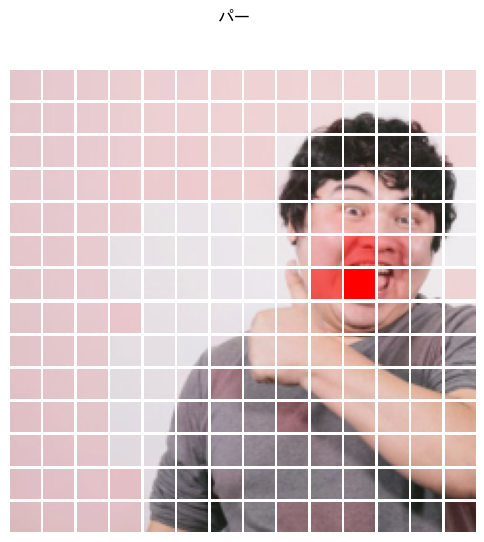

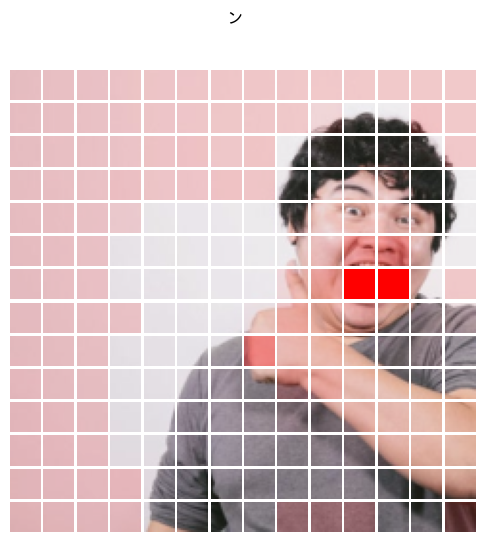

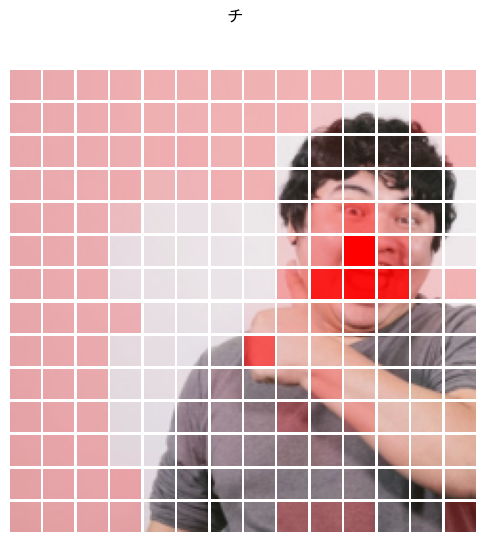

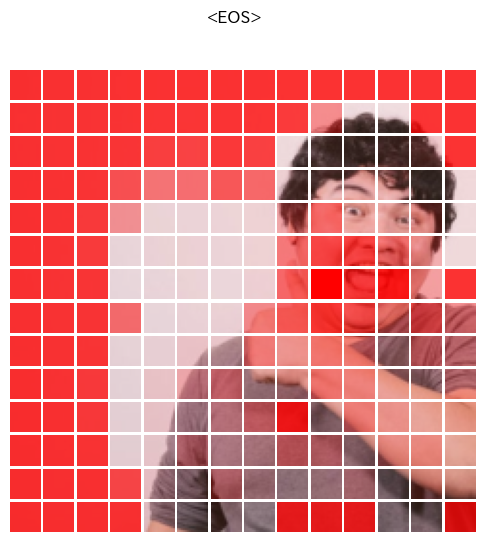

In [38]:
image_preprocesser = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def plot_attention_weights(pil_image, gen_text_index, tokenizer, image_preprocesser, layer = 0):
    attention_weights = gumi_t.get_cross_attention_weights(gen_text_index.unsqueeze(0), {"pixel_values": [pil_image]})
    # attention_weights = np.array([A.cpu().detach().numpy() for A in a])
    attention_weights = attention_weights[layer, 0, :, :]

    image = image_preprocesser(pil_image)
    patches = image.unfold(1, 16, 16).unfold(2, 16, 16)  # (3, 16, 16, 14, 14)
    patches = patches.permute(1, 2, 0, 3, 4)  # (16, 16, 3, 14, 14)

    for i in range(MAX_SENTENCE_LENGTH):
        fig, axs = plt.subplots(14, 14, figsize = (6, 6))
        fig.subplots_adjust(wspace=0.1, hspace=0.1)  # ← これを追加

        attention_scores = attention_weights[i]
        attention_scores = attention_scores / attention_scores.max()  # 0～1の値に正規化

        for j in range(14):
            for k in range(14):
                patch = patches[j, k]  # (3, 14, 14)
                patch_np = patch.permute(1, 2, 0).numpy()  # (14, 14, 3)
                alpha = attention_scores[j * 14 + k].item()  # 0～1の値

                # ヒートマップ色（赤）を作成
                overlay = np.zeros_like(patch_np)
                
                overlay[..., 0] = 1.0  # R=1（赤）
                overlay = alpha * overlay + (1 - alpha) * patch_np  # 色を混ぜる（線形補間）
                axs[j, k].imshow(overlay)
                axs[j, k].axis("off")

        fig.suptitle(tokenizer.decode([gen_text_index[i]]))
        plt.show()

        if gen_text_index[i] == 2: break

index = 8
plot_attention_weights(inputs["pixel_values"][index], torch.Tensor(tmp_tokenized_words).int().to(device), # gen_text_indexies[index], 
                       tokenizer, image_preprocesser, layer = 4)